<p style="font-family: Cambria; text-align: center; font-size: 48px;"> II. Descriptive Analysis</h1>

In [1]:
#Importing all the Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore", UserWarning)

In [7]:
#Reading the cleaned data 
data=pd.read_csv("covid_python_Dec25.csv",dtype={0: str})

In [9]:
#Creating a copy of the original data to work on, so that the original data is not modified
df=data.copy()

## Q1. What is the distribution of sex of the survey respondents?

In [11]:
df['sex'].map({ 'm': 'Male','f': 'Female','NR': 'Sex Not Recorded'}).value_counts()

sex
Sex Not Recorded    271042
Female               13254
Male                  9809
Name: count, dtype: int64

## Q2. What is the percentage of covid positive cases among the survey respondents ?

In [13]:
# Count positive cases
positive_count = df['covid_positive'].eq('positively').sum()

# Count respondents who actually reported a result (exclude 'NR')
tested_respondents = df['covid_positive'].isin(['negatively', 'n', 'positively']).sum()

# Calculate percentage
positive_percentage = (positive_count / tested_respondents) * 100

print("Number of Covid-positive cases:", positive_count)
print(f"Percentage of Covid-positive cases: {positive_percentage:.2f}%")

Number of Covid-positive cases: 22
Percentage of Covid-positive cases: 4.49%


## Q3. What is the distibution of covid positive cases by sex across the survey respondents ?

In [17]:
df.assign(
    sex=df['sex'].map({'m': 'Male', 'f': 'Female', 'NR': 'Not Reported'}),
    covid_status=df['covid_positive'].replace({
        'positively': 'Positive',
        'negatively': 'Negative',
        'NR': 'Not Reported'
    })
).groupby(['sex', 'covid_status']).size().unstack(fill_value=0)

covid_status,Negative,Not Reported,Positive
sex,,,
Female,231,13013,10
Male,87,9714,8
Not Reported,150,270888,4


## Q4. What percentage of cases are probable covid-19 in each province?

In [16]:
percentage_dist = pd.crosstab(
    df['province'],
    df['probable'],
    normalize='index'
) * 100

percentage_dist.round(2)

probable,n,y
province,,
Central Ontario,95.66,4.34
Eastern Ontario,95.33,4.67
Metropolitan Toronto,95.79,4.21
Northern Ontario,94.80,5.20
Southwestern Ontario,95.10,4.90


<p style="font-family: Cambria; text-align: center; font-size: 48px;">III. Prescriptive Analysis</h1>


## Identify the Marker Groups from the dataset.  

In [59]:
marker_groups = {
    "Demographics": ["age_category", "sex", "ethnicity"],
    "Symptoms": ["fever_chills_shakes", "cough", "shortness_of_breath"],
    "Exposure": ["travel_outside_canada", "contact_with_illness", "contact_in_household"],
    "Risk Factors": ["over_60", "any_medical_conditions"],
    "Mental Health": ["mental_health_impact"],
    "Outcome": ["covid_positive"]
}

##### The marker groups are Demographics, Symptoms, Exposure, Risk Factors, Mental Health, Outcome

<p style="font-family: Cambria; font-size: 16px;"><i><b>Q1. How do  symptom marker correlate with COVID-19 positivity?</i></b>
<p style="font-family: Cambria; font-size: 16px;"><b><i>Reasoning: Identifing which symptoms are most strongly associated with COVID-19 positivity is important so that infections can be detected earlier and more accurately. Understanding these correlations helps improve screening, testing prioritization, and public health responses, especially when testing resources are limited.</i></b>


In [44]:
covid_map = {
    "positively": 1,
    "negatively": 0,
    "NR": None  # missing values
}

df["covid_positive_num"] = df["covid_positive"].map(covid_map)

symptom_map = {"y": 1, "n": 0}

for col in ["fever_chills_shakes", "cough", "shortness_of_breath"]:
    df[col + "_num"] = df[col].map(symptom_map)

symptom_cols_num = ["fever_chills_shakes_num", "cough_num", "shortness_of_breath_num"]

symptom_corr = df[symptom_cols_num + ["covid_positive_num"]].corr()["covid_positive_num"].sort_values(ascending=False)
symptom_corr


covid_positive_num         1.000000
fever_chills_shakes_num    0.340556
cough_num                  0.289843
shortness_of_breath_num    0.256322
Name: covid_positive_num, dtype: float64

<p style="font-family: Cambria; font-size: 16px; color: green;"><strong><em>Key insight:<br>
fever_chills_shakes has the strongest positive correlation with a positive COVID test (0.34). People with fever/chills/shakes are more likely to test positive. cough and shortness_of_breath are also positively correlated (0.29, 0.26), but slightly weaker. Prioritize testing and rapid isolation for individuals reporting fever, chills, or shakes, as this symptom shows the strongest association with COVID-19 positivity and is a key early indicator of infection. Use cough and shortness of breath as secondary screening criteria, especially when combined with fever-related symptoms, to further refine testing.</em></strong></p>


<p style="font-family: Cambria; font-size: 16px;"><i><b>Q2. Based on the COVID positivity rate by province,how can we classify provinces into risk categories,and what public health measures should be recommended for each category?</i></b>
<p style="font-family: Cambria; font-size: 16px;"><b><i>Reasoning: classifying provinces into risk categories based on COVID-19 positivity rates allows public health authorities to prioritize interventions where they are most needed rather than applying uniform measures everywhere. By linking risk levels to specific public health actions, decision-makers can allocate testing, healthcare resources, and preventive measures more efficiently, reduce transmission in high-risk provinces.</i></b>






In [45]:
province_covid = (
    df.groupby("province")["covid_positive_num"]
      .mean()
      .sort_values(ascending=False)
)

province_covid


province
Central Ontario         0.061644
Metropolitan Toronto    0.059880
Southwestern Ontario    0.025974
Eastern Ontario         0.011111
Northern Ontario        0.000000
Name: covid_positive_num, dtype: float64

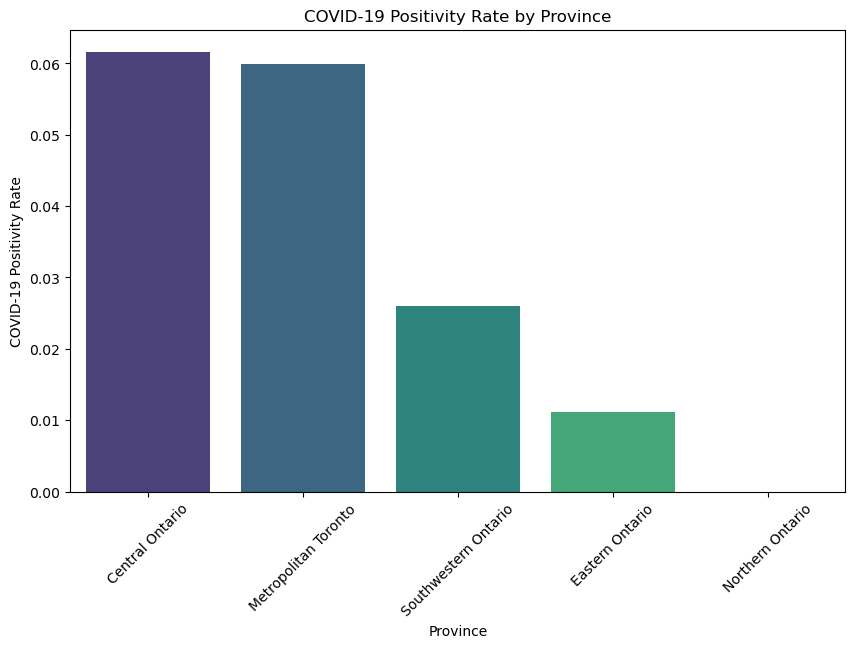

In [61]:
# Convert series to dataframe
df_plot = pd.DataFrame({
    "province": province_covid.index,
    "positivity": province_covid.values
})

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_plot,
    x="province",
    y="positivity",
    hue="province",       # Assign hue
    palette="viridis",
    dodge=False,
    legend=False          # Hide redundant legend
)
plt.ylabel("COVID-19 Positivity Rate")
plt.xlabel("Province")
plt.title("COVID-19 Positivity Rate by Province")
plt.xticks(rotation=45)
plt.show()

In [47]:
threshold_high = 0.10  # e.g., positivity > 10% considered high
threshold_moderate = 0.05  # positivity 5-10% moderate

prescriptions = {}

for prov, rate in province_covid.items():
    if rate > threshold_high:
        prescriptions[prov] = "High risk: Increase testing, strengthen restrictions, and allocate medical resources."
    elif rate > threshold_moderate:
        prescriptions[prov] = "Moderate risk: Maintain testing, monitor trends, promote awareness."
    else:
        prescriptions[prov] = "Low risk: Continue surveillance and preventive measures."
        
prescriptions


{'Central Ontario': 'Moderate risk: Maintain testing, monitor trends, promote awareness.',
 'Metropolitan Toronto': 'Moderate risk: Maintain testing, monitor trends, promote awareness.',
 'Southwestern Ontario': 'Low risk: Continue surveillance and preventive measures.',
 'Eastern Ontario': 'Low risk: Continue surveillance and preventive measures.',
 'Northern Ontario': 'Low risk: Continue surveillance and preventive measures.'}

<p style="font-family: Cambria; font-size: 16px; color: green;"><strong><em>Key insight:<br>
COVID-19 positivity is highest in densely populated regions like Central Ontario and Metropolitan Toronto, highlighting the need for targeted interventions. Less populated areas show very low positivity, suggesting that resource-intensive measures can be prioritized for high-risk areas while maintaining vigilance in low-risk provinces.</em></strong></p>

<p style="font-family: Cambria; font-size: 16px;"><i><b>Q3. What is the mental health impact of COVID-19 on survey respondents in rural versus urban regions?</i></b>
<p style="font-family: Cambria; font-size: 16px;"><b><i>Reasoning: understanding the mental health impact of COVID-19 in rural versus urban regions helps identify populations that may be disproportionately affected by stress, isolation, or limited access to mental health services. Comparing these regions enables policymakers and healthcare providers to design targeted mental health interventions, address access gaps, and allocate support resources more equitably during and after the pandemic.</i></b>




In [70]:
# Map mental health impact to numeric
mh_map = {
    "positively": 1,   # positive impact
    "negatively": -1,  # negative impact
    "NoImpact": 0,     # no impact
    "NR": None         # missing
}

df["mental_health_num"] = df["mental_health_impact"].map(mh_map)


In [71]:
region_mental = df.groupby("region")["mental_health_num"].mean()
region_mental


region
Rural   -0.860550
Urban   -0.853081
Name: mental_health_num, dtype: float64

In [72]:
prescriptions = {}

for region, mh_score in region_mental.items():
    if mh_score < -0.2:
        action = "High negative mental health impact: Deploy mental health support programs and counseling."
    elif mh_score < 0:
        action = "Moderate negative impact: Monitor mental health and provide guidance/resources."
    else:
        action = "No significant mental health intervention required."
    
    prescriptions[region] = action

prescriptions


{'Rural': 'High negative mental health impact: Deploy mental health support programs and counseling.',
 'Urban': 'High negative mental health impact: Deploy mental health support programs and counseling.'}

<p style="font-family: Cambria; font-size: 16px; color: green;"><strong><em>Key insight:<br>
Both Rural and Urban respondents report high negative mental health impact. This indicates that the pandemic is affecting mental well-being across all regions, not just urban centers. Prescriptive recommendation: Deploy mental health support programs and counseling services in both rural and urban areas to address the widespread negative impact.</em></strong></p>

<p style="font-family: Cambria; font-size: 16px;"><i><b>Q4. Are financial obligations a significant driver of negative mental health outcomes among COVID-19 survey respondents, or do other factors play a larger role??</i></b>
<p style="font-family: Cambria; font-size: 16px;"><b><i>Reasoning: understanding the mental health impact of COVID-19 in rural versus urban regions helps identify populations that may be disproportionately affected by stress, isolation, or limited access to mental health services. Comparing these regions enables policymakers and healthcare providers to design targeted mental health interventions, address access gaps, and allocate support resources more equitably during and after the pandemic.</i></b>


In [87]:
impact_map = {
    "positively": 1,
    "negatively": -1,
    "NoImpact": 0,
    "NR": None
}

df["mental_health_num"] = df["mental_health_impact"].map(impact_map)

# Split multi-select values into lists
df["financial_list"] = (
    df["financial_obligations_impact"]
    .replace("NR", "")
    .fillna("")
    .apply(lambda x: x.split(";"))
)

# Get unique financial obligation types
all_financial_cols = set(f for sublist in df["financial_list"] for f in sublist if f)

# Create binary columns
for col in all_financial_cols:
    df[col] = df["financial_list"].apply(lambda x: 1 if col in x else 0)

financial_cols = list(all_financial_cols)
correlations = {}

for col in financial_cols:
    corr = df[[col, "mental_health_num"]].dropna().corr().loc[col, "mental_health_num"]
    correlations[col] = corr


pd.DataFrame.from_dict(correlations, orient="index", columns=["Correlation_with_mental_health"]).sort_values(by="Correlation_with_mental_health", ascending=False)



,Correlation_with_mental_health
noneOfTheAbove,-0.001223
other,-0.004810
utilities,-0.005240
transportation,-0.008470
groceries,-0.014756
mortgagePayments,-0.018937
rent,-0.021004


<p style="font-family: Cambria; font-size: 16px; color: green;"><strong><em>Key insight:<br>
Financial obligations such as rent, mortgage payments, groceries, and utilities show a weak negative correlation with mental health impact.This suggests that while financial stress is directionally associated with poorer mental health, the relationship is not strong in this survey dataset.Therefore, financial burden alone does not fully explain mental health outcomes, and other factors such as social isolation, health concerns, may play a larger role.</em></strong></p>


<p style="font-family: Cambria; font-size: 16px;"><i><b>Q5. Which media channels are associated with greater negative mental health impact?</i></b>
<p style="font-family: Cambria; font-size: 16px;"><b><i>Reasoning: identifying media channels associated with greater negative mental health impact helps reveal how information consumption during a crisis can influence psychological well-being. Understanding these associations enables public health officials and media organizations to promote healthier communication strategies, reduce misinformation-driven stress, and guide individuals toward more balanced and supportive sources of information.</i></b>


In [88]:
impact_map = {
    "positively": 1,
    "negatively": -1,
    "NoImpact": 0,
    "NR": None
}

df["mental_health_num"] = df["mental_health_impact"].map(impact_map)

df["media_list"] = (
    df["media_channels"]
    .replace("NR", "")
    .fillna("")
    .apply(lambda x: x.split(";"))
)

media_cols = set(
    m for sublist in df["media_list"] for m in sublist if m
)

for col in media_cols:
    df[col] = df["media_list"].apply(lambda x: 1 if col in x else 0)

media_corr = {}

for col in media_cols:
    corr = (
        df[[col, "mental_health_num"]]
        .dropna()
        .corr()
        .loc[col, "mental_health_num"]
    )
    media_corr[col] = corr

pd.DataFrame.from_dict(
    media_corr,
    orient="index",
    columns=["Correlation_with_mental_health"]
).sort_values(by="Correlation_with_mental_health")



,Correlation_with_mental_health
reddit,-0.032276
tv,-0.027783
twitter,-0.021077
tumblr,-0.004136
radio,-0.003170
other,-0.001999
tiktok,-0.001266
facebook,0.000856
linkedin,0.001232
snapchat,0.008285


<p style="font-family: Cambria; font-size: 16px; color: green;"><strong><em>Key insight:<br>
Reddit, TV, Twitter show slight negative correlations,users of these platforms may experience more negative mental health impact. 
Media consumption patterns show minor but consistent associations with mental health outcomes.Platforms such as Reddit, TV, and Twitter are slightly associated with negative mental health impact, indicating a need for targeted mental health messaging and content moderation.Platforms such as Instagram, Sina Weibo, and newspapers show slight positive or neutral associations, suggesting they are suitable channels for disseminating reliable public health information.These insights can inform platform-specific interventions to mitigate adverse mental health effects during the COVID-19 pandemic.</em></strong></p>

